In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
import os
import time
import random

2024-06-04 23:58:06.396867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 23:58:06.396977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 23:58:06.530122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW  # Ensure tensorflow-addons is installed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [3]:
# data load
train_dir='/kaggle/input/chili-pepper/Kaggle_upload'
ds_health =glob.glob(train_dir + '/Healthy/*')
ds_anth =glob.glob(train_dir + '/Anthracnose/*')

print(len(ds_anth))
print(len(ds_health))

BATCH_SIZE = 32
IMAGE_SIZE = 224

dir = '/kaggle/working/'

2056
2399


In [4]:
# Define data preprocessing and data_generator

def create_data_generators(train_df, valid_df, test_df, batch_size, image_size):

    # Define a function to crop the image
    # Define the image cropping function using TensorFlow
    def crop_image(img):
    # Convert to TensorFlow tensor
        img = tf.convert_to_tensor(img, dtype=tf.float32)

        # Crop or pad image to 224x224
        crop_img = tf.image.resize_with_crop_or_pad(img, 2000,2000)

        return crop_img.numpy()

    # Define the ImageDataGenerator with the preprocessing function for training data
    train_generator = ImageDataGenerator(
       # horizontal_flip=True,
       # rotation_range=20,
        rescale=1/255.0,
       # preprocessing_function=crop_image
    )

    # Flow from DataFrame using train_generator for training data
    train_generator_iterator = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    train_batch, label_batch = next(train_generator_iterator)

    # Define the ImageDataGenerator with rescaling and preprocessing for validation data
    valid_generator = ImageDataGenerator(
       rescale=1/255.0,
      # preprocessing_function=crop_image
    )

   # Flow from DataFrame using valid_generator for validation data
    valid_generator_iterator = valid_generator.flow_from_dataframe(
       dataframe=valid_df,
       x_col='path',
       y_col='label',
       target_size=(image_size, image_size),
       class_mode="categorical",
       batch_size=batch_size,
       shuffle=True
   )
    valid_batch, valid_label_batch = next(valid_generator_iterator)

   # Define the ImageDataGenerator with only rescaling for test data
    test_generator = ImageDataGenerator(rescale=1/255.0)

   # Flow from DataFrame using test_generator for test data
    test_generator_iterator = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False)
    test_batch, test_label_batch = next(test_generator_iterator)

    return train_generator_iterator, valid_generator_iterator,test_generator_iterator




## Create model

In [5]:
# Define model list
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam ,AdamW, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.metrics import AUC

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
import tensorflow as tf


def create_model(model_type='mobilenet', in_shape=(224, 224, 3), n_classes=2):
   
        tf.keras.backend.clear_session()
        input_tensor = Input(shape=in_shape)

        # Connect input tensor to rescale and resize model
        if model_type == 'resnet50v2':
            base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
        elif model_type == 'xception':
            base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
        elif model_type =='mobilenet':
            base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_tensor=input_tensor)
        else:
            raise ValueError(f"Unknown model_type: {model_type}")
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        preds = Dense(units=n_classes, activation='sigmoid')(x)
        model = Model(inputs=base_model.input, outputs=preds)


        return model

## Train model

In [6]:
# Define model and run
in_shape = (224, 224, 3) 

def train_model(model_name,model_type, image_size, train, valid,fold):
    model = create_model(model_type=model_type, in_shape=in_shape)
    root_logdir = os.path.join(os.curdir, dir+"my_logs")

    def get_run_logdir():
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_" + model_name)
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    checkpoint_cb = ModelCheckpoint( dir + fold+model_name+"_model.keras", monitor="val_loss", save_best_only=True,
                                     verbose=1)
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                      restore_best_weights=False)
    reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,
                                     mode="min", verbose=1)

    model.compile(optimizer=AdamW(0.001), loss="binary_crossentropy", metrics=['accuracy'])
    
    history = model.fit(train,
                        validation_data=valid,
                        epochs=10,
                        callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
    return model,history

## Accuracy and loss graph

In [7]:
# Accuracy and loss graph

# Function to plot the training and validation accuracy and loss curves
def plot_metrics(history,model_name, fold):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # Initialize epoch count
    epoch_count = 0

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy curves
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    # Plot loss curves
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    
    plt.savefig(dir+fold+model_name+"_acc_loss.jpg", dpi=200)

    plt.show(history)


## Classification Report

In [8]:
#fixed with wrtn
import csv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def generate_classification_report(model,name,fold):
    # Create a LabelBinarizer object
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(test_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(test_gen_iter)
    predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환
    # Get classification report (including F1 score, precision, and recall)
    report = classification_report(true_labels, predicted_labels)
    
    print(report)    
    
    with open(dir+fold+name+'_report.csv', 'w') as file:
        writer = csv.writer(file)
        for line in report.split('\n'):
            writer.writerow(line.split(','))
        
        evaluation_results = model.evaluate(test_gen_iter)
        evaluation_results_header = ['Metric', 'Value']
            
#         writer.writerow(['Loss', evaluation_results[0]])
#         writer.writerow(['Accuracy', evaluation_results[1]])
        # 정확도(accuracy)를 계산합니다.
        sk_accuracy = accuracy_score(true_labels, predicted_labels)

        #confusion matrix 계산
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        print('Accuracy:', accuracy)
        writer.writerow(['tp',tp])
        writer.writerow(["fp",fp])
        writer.writerow(["fn",fn])
        writer.writerow(['tn',tn])
        writer.writerow(["precision", precision])
        writer.writerow(["recall",recall])
        writer.writerow(['f1score',f1_score])
        writer.writerow(['accuracy',accuracy])
        writer.writerow(['Loss', evaluation_results[0]])



        # 결과를 출력합니다.
        print("정확도: {:.4f}".format(sk_accuracy))



## Confusion matrix

In [9]:
# Define confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def generate_confusion_matrix(model,name,fold):
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(test_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(test_gen_iter)
    predicted_labels = np.argmax(predicted_labels, axis=1) 

    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    class_names = list(test_gen_iter.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(dir+fold+name +'_confusion_matrix.jpg', dpi=200,bbox_inches='tight')


In [12]:

# Step 2: Initialize the MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

def train_model_random_sample(model_name, model_type, image_size, train, valid, random_state, batch_size=32, epochs=100):

    # Create the model
    model = create_model(model_type=model_type, in_shape=(image_size, image_size, 3))


    # Define the root log directory
    root_logdir = os.path.join(os.curdir, dir+"my_logs")
    # Ensure the directory exists
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)

    print(f"Logs will be saved in: {os.path.abspath(root_logdir)}")

    # Function to get unique log directory
    def get_run_logdir():
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_") + model_name
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()


    checkpoint_cb = ModelCheckpoint( dir+random_state+model_name+"_model.keras", monitor="val_loss", save_best_only=True,
                                     verbose=1)
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                      restore_best_weights=False)
    reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,
                                     mode="min", verbose=1)

    model.compile(optimizer=AdamW(0.001), loss="binary_crossentropy", metrics=['accuracy'])

    history = model.fit(train,
                        validation_data=valid,
                        epochs=epochs,
                        callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
    return model, history




Found 3608 validated image filenames belonging to 2 classes.
Found 401 validated image filenames belonging to 2 classes.
Found 446 validated image filenames belonging to 2 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717545615.782451     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8355 - loss: 0.3255
Epoch 1: val_loss improved from inf to 3.17095, saving model to /kaggle/working/2xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.8361 - loss: 0.3246 - val_accuracy: 0.8753 - val_loss: 3.1709 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9680 - loss: 0.0875
Epoch 2: val_loss improved from 3.17095 to 0.25790, saving model to /kaggle/working/2xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9681 - loss: 0.0874 - val_accuracy: 0.9476 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9886 - loss: 0.0349
Epoch 3: val_loss did not improve from 0.25790
113/113 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.9886 - loss: 0.0350 - val_accuracy: 0.9426 - val_loss: 0.2989 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/

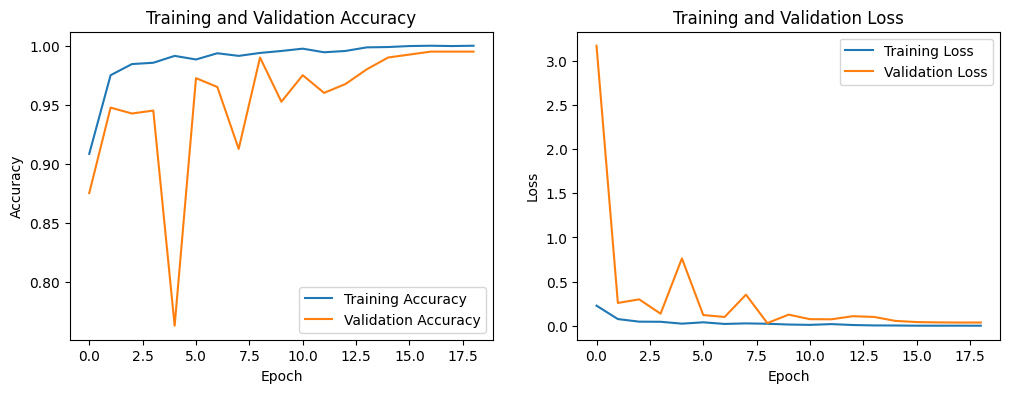

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       221
           1       0.99      1.00      0.99       225

    accuracy                           0.99       446
   macro avg       0.99      0.99      0.99       446
weighted avg       0.99      0.99      0.99       446

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9937 - loss: 0.0273
[[219   2]
 [  1 224]]
Accuracy: 0.9932735426008968
정확도: 0.9933


/kaggle/working/2xception_4455_bf_crop_history.txt

14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9937 - loss: 0.0273
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.024524, Test Accuracy : 99.327%
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step
[[219   2]
 [  1 224]]


/kaggle/working/2xception_4455_bf_crop_history.txt

Found 3608 validated image filenames belonging to 2 classes.
Found 401 validated image filenames belonging to 2 classes.
Found 446 validated image filenames belonging to 2 classes.
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8830 - loss: 0.2567
Epoch 1: val_loss improved from inf to 1.66316, saving model to /kaggle/working/42xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8834 - loss: 0.2559 - val_accuracy: 0.6983 - val_loss: 1.6632 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9738 - loss: 0.0796
Epoch 2: val_loss improved from 1.66316 to 0.17642, saving model to /kaggle/working/42xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.9738 - loss: 0.0796 - val_accuracy: 0.9651 - val_loss: 0.1764 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9868 - loss: 0.0576
Epoch 3: val_loss improved from 0.17642 to 0.15738, saving model to /kaggle/working/42xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.9867 - loss: 0.0577 - val_accuracy: 0.9726 - val_loss: 0.1

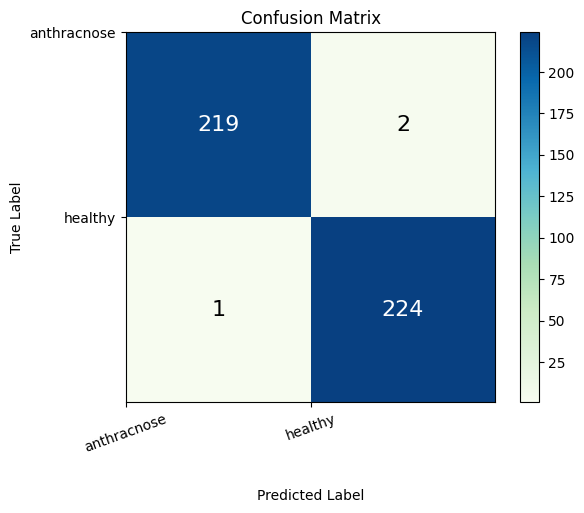

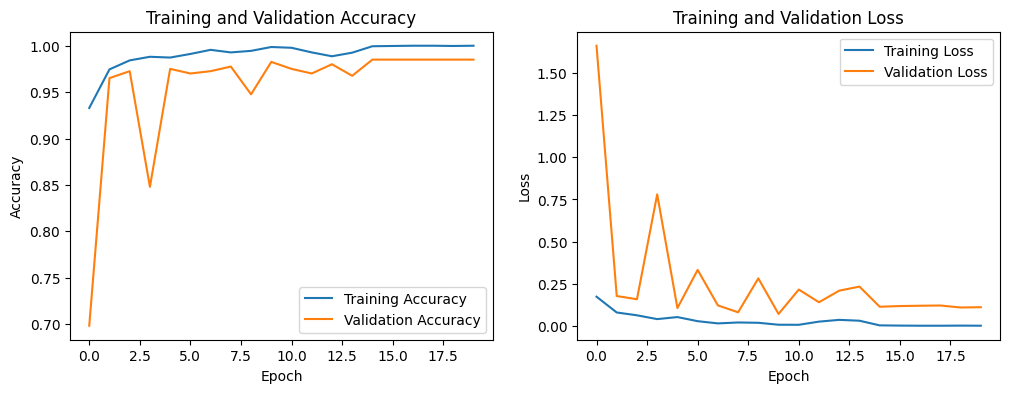

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       203
           1       0.98      0.99      0.99       243

    accuracy                           0.98       446
   macro avg       0.98      0.98      0.98       446
weighted avg       0.98      0.98      0.98       446

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9745 - loss: 0.2025
[[198   5]
 [  2 241]]
Accuracy: 0.984304932735426
정확도: 0.9843


/kaggle/working/42xception_4455_bf_crop_history.txt

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9745 - loss: 0.2025
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.112394, Test Accuracy : 98.430%
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
[[198   5]
 [  2 241]]


/kaggle/working/42xception_4455_bf_crop_history.txt

Found 3608 validated image filenames belonging to 2 classes.
Found 401 validated image filenames belonging to 2 classes.
Found 446 validated image filenames belonging to 2 classes.
Logs will be saved in: /kaggle/working/my_logs
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8880 - loss: 0.2517
Epoch 1: val_loss improved from inf to 10.18891, saving model to /kaggle/working/123xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.8884 - loss: 0.2511 - val_accuracy: 0.8828 - val_loss: 10.1889 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9734 - loss: 0.0770
Epoch 2: val_loss improved from 10.18891 to 1.80848, saving model to /kaggle/working/123xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.9733 - loss: 0.0771 - val_accuracy: 0.8504 - val_loss: 1.8085 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9871 - loss: 0.0462
Epoch 3: val_loss improved from 1.80848 to 0.28114, saving model to /kaggle/working/123xception_4455_bf_crop_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.9870 - loss: 0.0462 - val_accuracy: 0.9651 - val_los

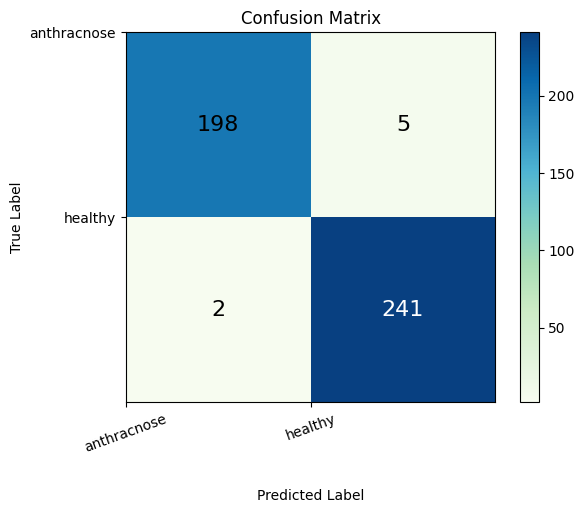

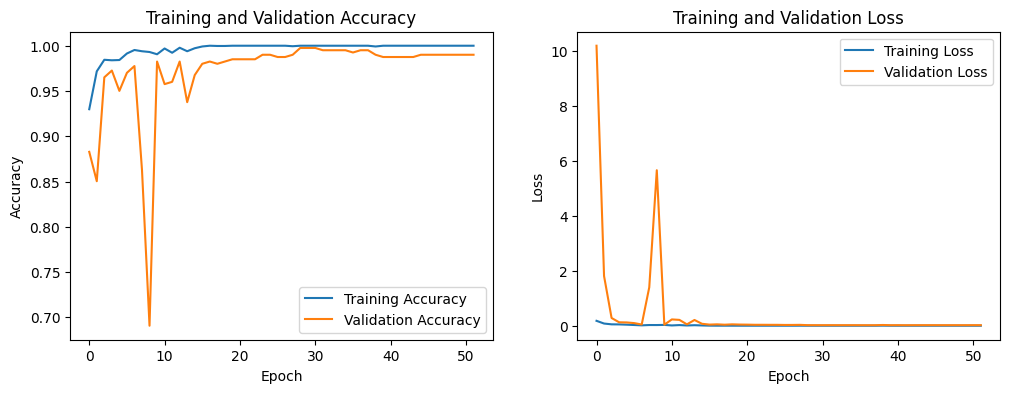

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00       235

    accuracy                           1.00       446
   macro avg       1.00      1.00      1.00       446
weighted avg       1.00      1.00      1.00       446

14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9992 - loss: 0.0057
[[210   1]
 [  0 235]]
Accuracy: 0.9977578475336323
정확도: 0.9978


/kaggle/working/123xception_4455_bf_crop_history.txt

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9992 - loss: 0.0057
compile_metrics
{'anthracnose': 0, 'healthy': 1}
Test Loss : 0.014653, Test Accuracy : 99.776%
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
[[210   1]
 [  0 235]]


/kaggle/working/123xception_4455_bf_crop_history.txt

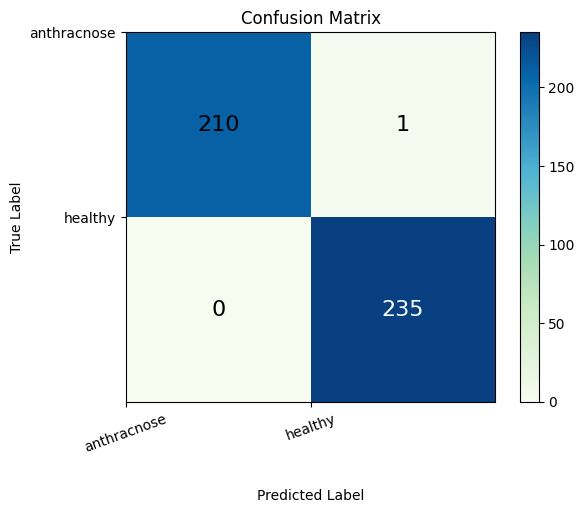

In [13]:
from IPython.display import FileLink
from IPython.core.magic import register_line_cell_magic
from io import StringIO
import sys


# List of random states
random_state_list = [2,42,123]

# Loop to train the model with different random states
for random_state in random_state_list:
    fold_n = str(random_state)

    train_path = ds_health + ds_anth
    train_label = ["healthy" for _ in range(len(ds_health))] + ["anthracnose" for _ in range(len(ds_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
    sample_data = pd.DataFrame({"path":train_path, "label":train_label})

    # Assuming 'image_path' and 'label' columns exist in the dataframe
    train_df, test_df = train_test_split(sample_data, test_size=0.1, random_state=random_state)
    train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=random_state)

    train_gen_iter, valid_gen_iter,test_gen_iter  = create_data_generators(train_df=train_df,valid_df=valid_df,test_df=test_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE)
    
    output_path = f'{dir}{random_state}{model_name}_output.txt'


    # Train the model
    model, history = train_model_random_sample(model_name, model_type, image_size=IMAGE_SIZE,
                                 train=train_gen_iter,valid=valid_gen_iter, random_state=str(random_state))
 

    # Save the training history to a text file
    history_path = f'{dir}{random_state}{model_name}_history.txt'
    with open(history_path, 'w') as f:
        for key, values in history.history.items():
            f.write(f"{key}: {values}\n")
            
     # Training visualization
    plot_metrics(history,model_name,fold=fold_n)

    # classification report
    generate_classification_report(model=model,name=model_name,fold=fold_n)
    display(FileLink(history_path))
    
    scores = model.evaluate(test_gen_iter) 
    print(f'{model.metrics_names [1]}')
    print(test_gen_iter.class_indices)
    print('Test Loss : {:.6f}, Test Accuracy : {:.3f}%'. format (scores [0], scores [1]*100))
  

    # confusion matrix
    generate_confusion_matrix(model=model,name=model_name,fold=fold_n)
    display(FileLink(history_path))
    

# Hold out validation with best model

In [13]:
e_test_dir='/home/nanopore/pepper/Kaggle_upload(chili-pepper)-seperated/early-test'
et_health =glob.glob(e_test_dir + '/healthy/*')
et_anth =glob.glob(e_test_dir + '/anthracnose/*')
print(len(et_health))
print(len(et_anth))

50

50


In [24]:
test_path = t_health + t_anth
test_label = ["Healthy" for _ in range(len(t_health))] + ["Anthracnose" for _ in range(len(t_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
test_df = pd.DataFrame({"path":test_path, "label":test_label})


In [14]:
etest_path = et_health + et_anth
etest_label = ["Healthy" for _ in range(len(et_health))] + ["Anthracnose" for _ in range(len(et_anth))] # + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
etest_df = pd.DataFrame({"path":etest_path, "label":etest_label})

In [25]:
image_size = 224
batch_size = 32
# Define the ImageDataGenerator with only rescaling for test data
test_generator = ImageDataGenerator(rescale=1/255.0)

# Flow from DataFrame using test_generator for test data
test_generator_iterator = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False)
test_batch, test_label_batch = next(test_generator_iterator)

Found 446 validated image filenames belonging to 2 classes.


In [15]:
image_size = 224
batch_size = 32
# Define the ImageDataGenerator with only rescaling for test data
etest_generator = ImageDataGenerator(rescale=1/255.0)

# Flow from DataFrame using test_generator for test data
etest_generator_iterator = etest_generator.flow_from_dataframe(
    dataframe=etest_df,
    x_col='path',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False)
etest_batch, etest_label_batch = next(etest_generator_iterator)

Found 100 validated image filenames belonging to 2 classes.


## Load model

In [31]:
from tensorflow.keras.models import load_model

model_path = '/home/nanopore/pepper/models/MobileNet/3000/2mobilenet_3000_model.keras'
model = load_model(model_path)
name = '/home/nanopore/pepper/models/MobileNet/3000/test_2mobilenet_3000'
ename='/home/nanopore/pepper/models/MobileNet/3000/etest_2mobilenet_3000'

## Classification Report

In [32]:
#fixed with wrtn
import csv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def generate_classification_report(model,data_df,data_gen, name):
    # Create a LabelBinarizer object
    lb = LabelBinarizer()

    # Fit the label binarizer to the label column
    lb.fit(data_df['label'])

    # Transform the label column to binary list
    label_list = lb.transform(data_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)

    predicted_labels = model.predict(data_gen)
    predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환
    # Get classification report (including F1 score, precision, and recall)
    report = classification_report(true_labels, predicted_labels)
    
    print(report)    
    
    with open(name+'_report.csv', 'w') as file:
        writer = csv.writer(file)
        for line in report.split('\n'):
            writer.writerow(line.split(','))
        
        evaluation_results = model.evaluate(data_gen)
        evaluation_results_header = ['Metric', 'Value']
 
        # 정확도(accuracy)를 계산합니다.
        sk_accuracy = accuracy_score(true_labels, predicted_labels)

        #confusion matrix 계산
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

        tn, fp, fn, tp = cm.ravel()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        print('Accuracy:', accuracy)
        writer.writerow(['tp',tp])
        writer.writerow(["fp",fp])
        writer.writerow(["fn",fn])
        writer.writerow(['tn',tn])
        writer.writerow(["precision", precision])
        writer.writerow(["recall",recall])
        writer.writerow(['f1score',f1_score])
        writer.writerow(['accuracy',accuracy])
        writer.writerow(['Loss', evaluation_results[0]])
        writer.writerow(['Accuracy', evaluation_results[1]])


        # 결과를 출력합니다.
        print("정확도: {:.4f}".format(sk_accuracy))

        class_names = list(data_gen.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(name +'_confusion_matrix.jpg', dpi=200,bbox_inches='tight')


/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

  if is_sparse(pd_dtype):

/home/nanopore/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step

              precision    recall  f1-score   support



           0       0.98      0.97      0.97       206

           1       0.97      0.98      0.98       240



    accuracy                           0.98       446

   macro avg       0.98      0.97      0.98       446

weighted avg       0.98      0.98      0.98       446



14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9833 - loss: 0.0551

[[199   7]

 [  4 236]]

Accuracy: 0.9753363228699552

정확도: 0.9753


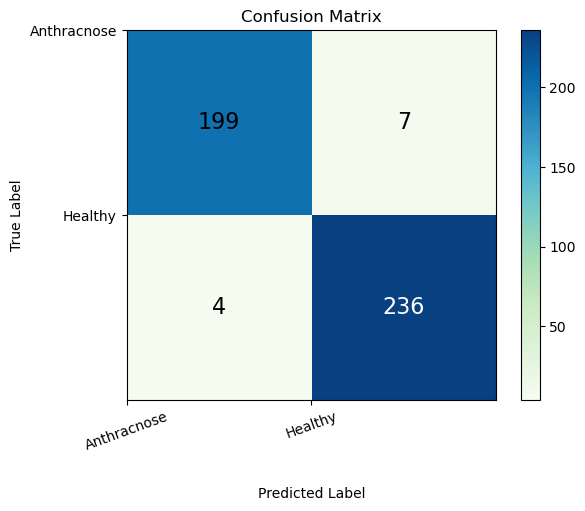

In [33]:
generate_classification_report(model=model,data_df=test_df,data_gen=test_generator_iterator,name=name)

## t-SNE visualization

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def tsne_v(model,name, data):
    def extract_features(model, data):
        # 주어진 모델의 입력과 'global_average_pooling2d' 레이어의 출력을 연결하는 모델, 이를 통해 모델의 특성을 추출
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)
        features = feature_extractor.predict(data)
        return features

    # 모델과 데이터로부터 특성 추출
    features = extract_features(model,test_generator_iterator)
    # TSNE를 사용하여 2차원으로 차원 축소
    tsne = TSNE(n_components=2,perplexity=5).fit_transform(features)
    # 시각화할 데이터 포인트의 색상과 레이블 설정
    colors_per_class = {
        'Anthracnose' : 'red',
        'Healthy': 'blue'
    }

    # 시각화할 데이터 포인트의 색상 저장하는 리스트 초기화
    scatter_colors = []

    # test_df의 각 데이터 포인트에 대해 색상을 저장
    for _, data_point in test_df.iterrows():
        color = colors_per_class[data_point['label']]
        scatter_colors.append(color)

    # 산점도 그리기
    plt.scatter(tsne[:, 0], tsne[:, 1], c=scatter_colors)

    # 그래프 제목 설정
    plt.title("t-SNE Visualization")

    # x축, y축 레이블 설정
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")

    # 범례 항목 생성
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors_per_class.items()]

    # 범례 표시
    plt.legend(handles=legend_patches)

    # 그래프 출력
    plt.savefig(name+'_t-sne.png',dpi=200)
    plt.show()
    